In [1]:
import pickle

✅ Loaded metrics for all models:
                model  layer_idx  hit@1  ndcg_linear@1  ndcg_exponential@1
0  VLM2Vec-Qwen2VL-2B          1  0.002          0.002               0.002
1  VLM2Vec-Qwen2VL-2B          2  0.001          0.001               0.001
2  VLM2Vec-Qwen2VL-2B          3  0.001          0.001               0.001
3  VLM2Vec-Qwen2VL-2B          4  0.000          0.000               0.000
4  VLM2Vec-Qwen2VL-2B          5  0.001          0.001               0.001


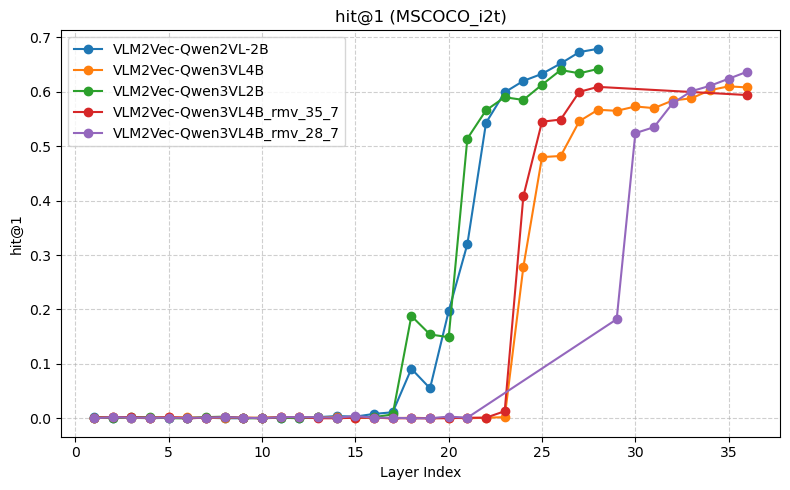

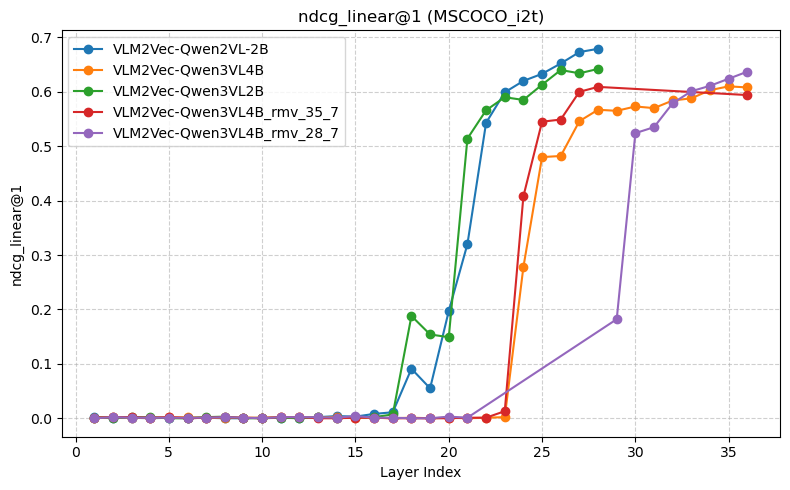

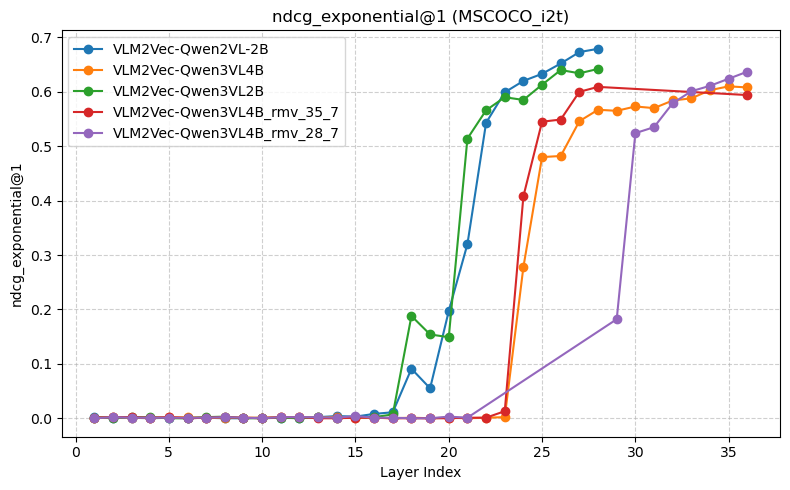

✅ Loaded metrics for all models:
                model  layer_idx  hit@1  ndcg_linear@1  ndcg_exponential@1
0  VLM2Vec-Qwen2VL-2B          1  0.005          0.005               0.005
1  VLM2Vec-Qwen2VL-2B          2  0.005          0.005               0.005
2  VLM2Vec-Qwen2VL-2B          3  0.000          0.000               0.000
3  VLM2Vec-Qwen2VL-2B          4  0.000          0.000               0.000
4  VLM2Vec-Qwen2VL-2B          5  0.000          0.000               0.000


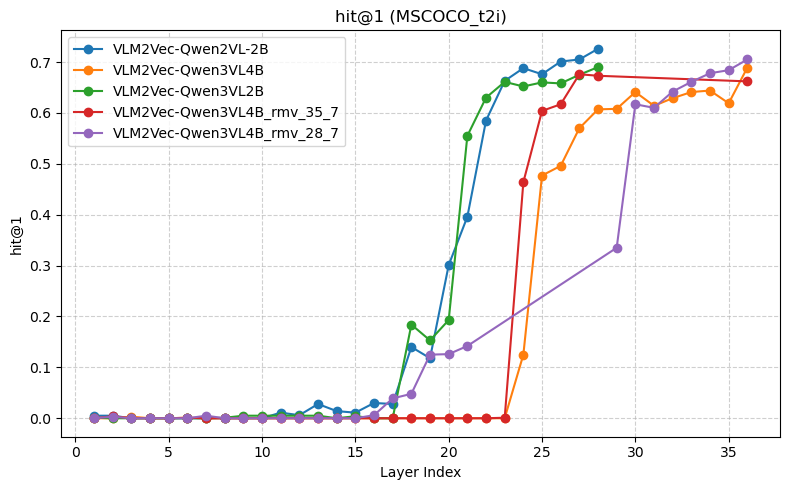

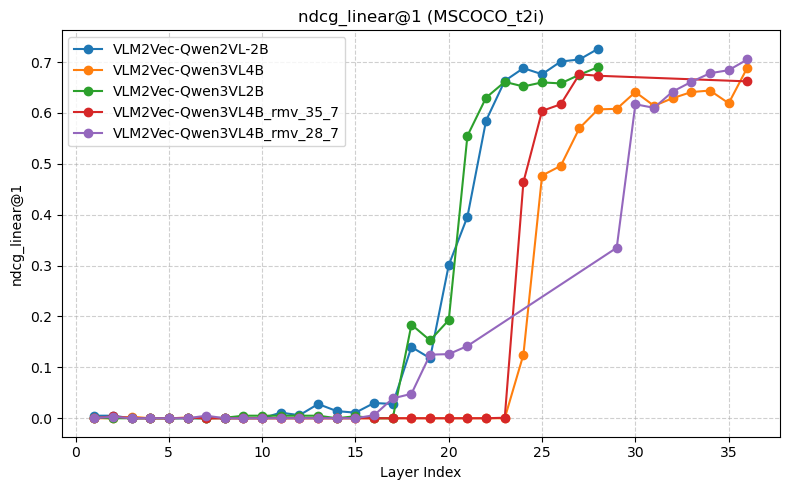

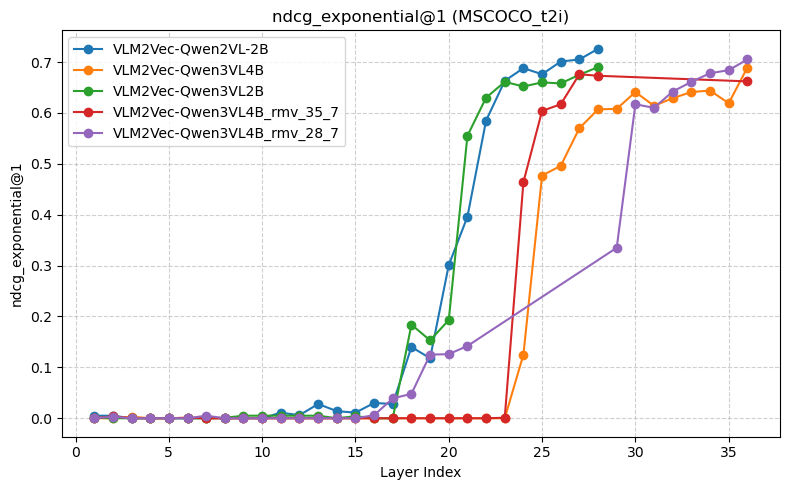

In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# =============================================
# Configuration
# =============================================

# List of model directories
model_dirs = {
    # "Qwen2-VL-7B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/vlm2vec_retrieval/qwen-Qwen2-VL-7B-Instruct",
    # "InternVL-2-8B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/vlm2vec_retrieval/internvl2-8b",
    # "MiniCPM-V": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/vlm2vec_retrieval/minicpm-v",
    # "gme-Qwen2-VL-2B-Instruct": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/vlm2vec_retrieval/gme-Qwen2-VL-2B-Instruct",
    # "VLM2Vec-V2.0-Qwen2VL-2B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/vlm2vec_retrieval/VLM2Vec-V2.0-Qwen2VL-2B",
    "VLM2Vec-Qwen2VL-2B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/original/qwen-Qwen2-VL-2B-Instruct",
    # "AddTail-Qwen2-VL-2B-ckpt1500": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_19Nov_AddTail-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-500",
    # "AddTail-Qwen2-VL-2B-ckpt3000": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_19Nov_AddTail-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-3000",
    # "AddTail-Qwen2-VL-2B-ckpt3500": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_19Nov_AddTail-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-3500",
    # "AddTail-Qwen2-VL-2B-ckpt4500": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_19Nov_AddTail-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-4500",
    # "AddTail-Qwen2-VL-2B-ckpt6000": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_19Nov_AddTail-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-6000",
    # "AddTail_Replace-Qwen2-VL-2B-ckpt100": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_19Nov_AddTail_Replace-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-100",
    # "AddTail_Replace-Qwen2-VL-2B-ckpt200": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_19Nov_AddTail_Replace-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-200",
    # "AddTail_Replace-Qwen2-VL-2B-ckpt300": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_19Nov_AddTail_Replace-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-300",
    # "AddTail_Replace-Qwen2-VL-2B-ckpt2350": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_19Nov_AddTail_Replace-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-2350",
    # "AddTail_Replace-Qwen2-VL-2B-ckpt6000": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_19Nov_AddTail_Replace-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-6000",
    # "AddTail_TrainOnly_Replace-Qwen2-VL-2B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_19Nov_AddTail_TrainOnly_Replace-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-6000",
    # "AddTail_TrainOnly-Qwen2-VL-2B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_19Nov_AddTail_TrainOnly-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-6000",
    # "Train_on_layer23": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_25Nov_loss23-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-2750",
    # "AddTail_EosInit": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_26Nov_TailEosInit-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-6000",
    # "AddTail_EosInit-MoreDataset-500": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_27Nov_NewDatasets_TailEosInit-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-500",
    # "AddTail_EosInit-MoreDataset-3000": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_27Nov_NewDatasets_TailEosInit-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-3000",
    # "AddTail_EosInit--MoreDataset-6000": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_27Nov_NewDatasets_TailEosInit-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-6000",
    # "Train_on_16": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_28Nov_TrLayer16-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-6000",
    # "Train_on_8": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_28Nov_TrLayer8-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-6000",
    # "Remove_1-10": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_02Dec_Delete1-10-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-6000",
    # "Train_on_16_28": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_10DecAddLoss_28_16-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-2000",
    # "Train_on_8_28": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_12DecAddLoss_28_8-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-4000",
    # "Remove_23-27": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_10DecRmvLayer-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-6000",
    # "Remove_18-22": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_12DecRmvLayer_22_5-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-3000",
    "VLM2Vec-Qwen3VL4B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_15Dec_Qwen3VL4b_original-Qwen/qwen-Qwen3-VL-4B-Instruct/checkpoint-2500",
    # "VLM2Vec-Qwen3VL4B_2000": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_15Dec_Qwen3VL4b_original-Qwen/qwen-Qwen3-VL-4B-Instruct/checkpoint-2000",
    # "VLM2Vec-Qwen3VL4B_1500": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_15Dec_Qwen3VL4b_original-Qwen/qwen-Qwen3-VL-4B-Instruct/checkpoint-1500",
    "VLM2Vec-Qwen3VL2B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_17Dec_Qwen3VL2B_original-Qwen/qwen-Qwen3-VL-2B-Instruct/checkpoint-4500",
    "VLM2Vec-Qwen3VL4B_rmv_35_7": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_17Dec_Qwen3VL4B_rmv_35_7-Qwen/qwen-Qwen3-VL-4B-Instruct/checkpoint-4500",
    "VLM2Vec-Qwen3VL4B_rmv_28_7": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/DEBUG_5Jan_Qwen3VL4b_rmv_28_7-Qwen/qwen-Qwen3-VL-4B-Instruct/checkpoint-4000",
    }

# Metrics to extract
metrics_to_read = [
    "hit@1", "ndcg_linear@1", "ndcg_exponential@1",
    # "hit@5", "ndcg_linear@5", "ndcg_exponential@5",
]

# Target dataset
# task_name = "FashionIQ"
task_names = ["MSCOCO_i2t", "MSCOCO_t2i"]

# =============================================
# Helper functions
# =============================================

def get_layer_index(name):
    """Extract numeric layer index from folder name like 'layer_12'."""
    try:
        return int(name.split("_")[1])
    except Exception:
        return 1e9  # non-layer folders sorted to end

def collect_model_data(model_name, model_dir):
    """Collect retrieval metrics for a given model."""
    results = []

    if "retrieval" in os.listdir(model_dir):
        model_dir = os.path.join(model_dir, "retrieval")
    for child_name in sorted(os.listdir(model_dir), key=get_layer_index):
        if not child_name.startswith("layer_"):
            continue
        if child_name.endswith("layer_0"):
            continue

        child_path = os.path.join(model_dir, child_name)
        if "retrieval" in os.listdir(child_path):
            score_path = os.path.join(child_path, "retrieval", f"{task_name}_score.json")
        else:
            score_path = os.path.join(child_path, f"{task_name}_score.json")

        if not os.path.exists(score_path):
            print(f"⚠️  Skipping: {score_path} not found.")
            continue

        with open(score_path, "r") as f:
            data = json.load(f)

        record = {
            "model": model_name,
            "layer_idx": get_layer_index(child_name)
        }
        for key in metrics_to_read:
            record[key] = data.get(key, None)
        results.append(record)

    if not results:
        print(f"⚠️  No valid results found for model {model_name}.")
        return None

    return pd.DataFrame(results).sort_values("layer_idx")


for task_name in task_names:
        
    # =============================================
    # Step 1: Collect data for all models
    # =============================================

    all_data = []
    for model_name, model_dir in model_dirs.items():
        df_model = collect_model_data(model_name, model_dir)
        if df_model is not None:
            all_data.append(df_model)

    if not all_data:
        raise RuntimeError("No valid score files found for any model.")

    df_all = pd.concat(all_data, ignore_index=True)
    print("✅ Loaded metrics for all models:")
    print(df_all.head())

    # =============================================
    # Step 2: Plot all models on the same figure for each metric
    # =============================================


    for metric in metrics_to_read:
        plt.figure(figsize=(8, 5))
        for model_name in model_dirs.keys():
            df_model = df_all[df_all["model"] == model_name]
            # if model_name.startswith("Delete"):
            #     plt.plot(df_model["layer_idx"]+10, df_model[metric],
            #             marker="o", label=model_name)
            # else:
            plt.plot(df_model["layer_idx"], df_model[metric],
                    marker="o", label=model_name)

        plt.title(f"{metric} ({task_name})")
        plt.xlabel("Layer Index")
        plt.ylabel(metric)
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()
